# 5. Decision trees and random forest

Can you do better than the logistic regression with tree methods which are nonlinear?

- What accuracy can you achieve using a decision trees with a depth of 3? Plot the corresponding decision tree with plot_tree() (see here for more)
- Tune the depth of your decision tree. Does it improve the accuracy?
(Optional) Do you get better results with your decision tree if you reduce the number of dimensions with PCA first?
- Try a random forest model and tune the number of trees and their depth. Does increasing the number of trees help? Is there an optimal depth and how does it compare to your decision tree above?
- The random forest estimator provides a ranking of the features according to their importance in the classification task via thefeature_importances_ attribute. Find the the top 5 important features and visualize their importance scores.
- Are these top features similar to the ones you found based on the coefficients in the logistic regression task, and also during the data exploration in the last question of Task 1?

In [39]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
import matplotlib.image as mpimg
import tensorflow as tf
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

In [40]:
with np.load('train_data_np.npz', allow_pickle=False) as npz_file_tr:
    # Load the arrays
    X_tr = npz_file_tr['features']
    y_tr = npz_file_tr['targets']

In [41]:
with np.load('test_data_np.npz', allow_pickle=False) as npz_file_te:
    # Load the arrays
    X_te = npz_file_te['features']
    y_te = npz_file_te['targets']

In [42]:
with np.load('val_data_np.npz', allow_pickle=False) as npz_file_val:
    # Load the arrays
    X_val = npz_file_val['features']
    y_val = npz_file_val['targets']

In [43]:
# Folder list
folder_list = ["bike", "car", "motorcycle", "other", "truck", "van"]

In [44]:
X_tr = X_tr.reshape(280, 1280)
X_te = X_te.reshape(52, 1280)
X_val = X_val.reshape(139,1280)

## What accuracy can you achieve using a decision trees with a depth of 3? Plot the corresponding decision tree with plot_tree() (see here for more)

*Comments:* We create the decision tree using a depth of 3, gini as measure of impurity and random state at 0 to ensure the reproductibility of results

In [45]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

# Create a decision tree pipeline with max_depth=3
dt_pipe = Pipeline(
    [("scaler", StandardScaler()), ("dt", DecisionTreeClassifier(criterion="gini", max_depth=3, random_state=0))]
)


In [46]:
# Fit the pipeline
dt_pipe.fit(X_tr, y_tr)

# Get score
dt_pipe.score(X_tr, y_tr)

0.7535714285714286

*Comments:* The accuracy is 75% which is well below the 94% reached with logistic regression.
### Decision tree
To plot the decision tree, we cannot use include the 1280 features, consequencently I am selecting the 10 most features based on their importance. The importance of a feature is computed as the (normalized) total reduction of the criterion brought by that feature. It is also known as the Gini importance.

In [47]:
# Checking the proportion of each class
pd.value_counts(y_tr, normalize=True)

bike          0.235714
car           0.228571
motorcycle    0.182143
truck         0.150000
other         0.114286
van           0.089286
dtype: float64

In [48]:
# Standardize data
scaler = StandardScaler()
X_tr_standardized = scaler.fit_transform(X_tr)
# Build and fit the estimator
dt_reduced = DecisionTreeClassifier(criterion="gini", max_depth=3, random_state=0)
dt_reduced.fit(X_tr_standardized, y_tr)

DecisionTreeClassifier(max_depth=3, random_state=0)

In [49]:
# Calculation of Gini importance
feature_importances = dt_reduced.feature_importances_

In [50]:
# Selecting top features
top_indices = np.argsort(feature_importances)[-10:] 
top_indices

array([ 423,  407,  406,  877,  110, 1136,   28,  892,  783,  999],
      dtype=int64)

In [51]:
# Train a new tree with only the top features
X_tr_reduced = X_tr_standardized[:, top_indices]  # Use only top features

In [52]:
# Create feature names on top features
feature_names = [f"Feature {i}" for i in top_indices]
feature_names

['Feature 423',
 'Feature 407',
 'Feature 406',
 'Feature 877',
 'Feature 110',
 'Feature 1136',
 'Feature 28',
 'Feature 892',
 'Feature 783',
 'Feature 999']

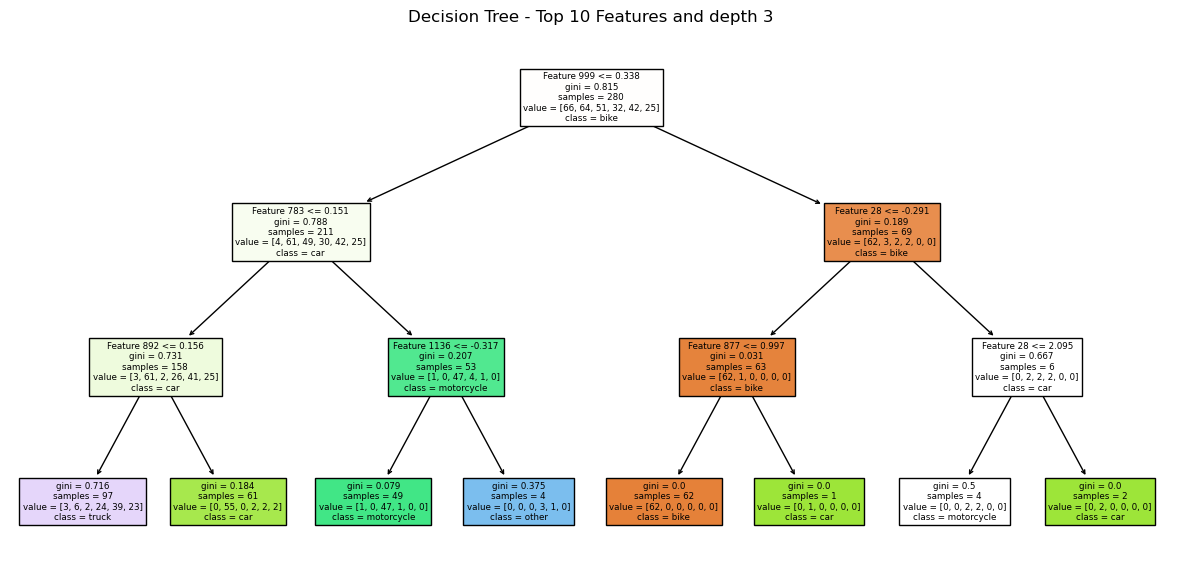

In [53]:
from sklearn import tree
# Train a new decision tree on the reduced feature set
dt_reduced.fit(X_tr_reduced, y_tr)

# Plot the reduced decision tree
plt.figure(figsize=(15, 7))
tree.plot_tree(
    dt_reduced,
    feature_names=feature_names,
    class_names=folder_list,
    filled=True
)
plt.title("Decision Tree - Top 10 Features and depth 3")
plt.show()

*Comments:* The Gini impurity is high for the truck class, but we can see a low purity index on the bike and car class meaning that the models manages the classification well for these groups. The models is successfull to assess motorcycles in certain circumstances; if the feature 999 is below, 0,338, if the feature 783 is below 0,151 and if the feature 1136 is below -0,317. 

### Tune the depth of your decision tree. Does it improve the accuracy? (Optional) Do you get better results with your decision tree if you reduce the number of dimensions with PCA first?
We are tuning the model on depth values based on all features to visualize the train and validation curves

In [54]:
#Tuning the model based on various depth (d) values 

# Generate a set of  values
d_values = [1, 2, 4, 6, 8, 10, 12, 14, 16]
d_values

[1, 2, 4, 6, 8, 10, 12, 14, 16]

In [55]:
X_tr.shape, y_tr.shape, X_val.shape, y_val.shape

((280, 1280), (280,), (139, 1280), (139,))

In [56]:
# Variable to store the results
gs_results = []

# Grid search
for d in d_values:
    # Fit decision tree model
    dt_pipe.set_params(dt__max_depth=d)

    dt_pipe.fit(X_tr, y_tr)

    # Save model and its performance on training/validation sets
    gs_results.append(
        {
            "depth": d,
            "train_accuracy": dt_pipe.score(X_tr, y_tr),
            "valid_accuracy": dt_pipe.score(X_val, y_val),
        }
    )

# Convert results to DataFrame
gs_results = pd.DataFrame(gs_results)
gs_results.sort_values(by="valid_accuracy", ascending=False).head()

,depth,train_accuracy,valid_accuracy
3,6,0.939286,0.733813
5,10,1.000000,0.697842
6,12,1.000000,0.697842
7,14,1.000000,0.697842
8,16,1.000000,0.697842


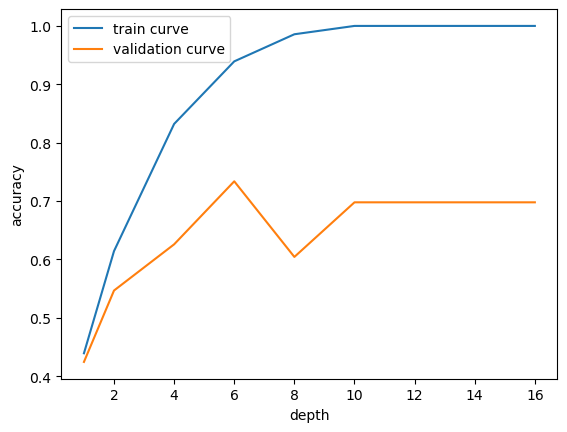

In [57]:
%matplotlib inline
import matplotlib.pyplot as plt

# Plot the validation curves
plt.plot(gs_results["depth"], gs_results["train_accuracy"], label="train curve")
plt.plot(gs_results["depth"], gs_results["valid_accuracy"], label="validation curve")
plt.ylabel("accuracy")
plt.xlabel("depth")
plt.legend()
plt.show()

In [58]:
# Get entry with the best validation MSE
best_result = gs_results.loc[gs_results.valid_accuracy.idxmax()]

# Print the details
print("Best depth: {}".format(best_result.depth))
print("Validation Accuracy: {:.4f}".format(best_result.valid_accuracy))

Best depth: 6.0
Validation Accuracy: 0.7338


*Comments:* We can see that increasing the dept of the decision tree improves the validation set accuracy up to a depth of 6 and an accuracy at 73%. However, above 6,0, the accuracy of the validation curve decreases sharply before platauing 70% while the train set curve reached 100%. It clearly indicates overfitting. We can try to reduce again the number of features 

In [59]:
from sklearn.decomposition import PCA

In [60]:
pca = PCA(n_components=2)
X_val_standardized = scaler.transform(X_val)
# Apply PCA to rescaled data
X_tr_pca = pca.fit_transform(X_tr_standardized)
X_val_pca = pca.transform(X_val_standardized)

In [61]:
# Variable to store the results
gs_results_pca = []

# Grid search
for d in d_values:
    # Fit decision tree model with pca_transformed data
    dt_pca =DecisionTreeClassifier(criterion="gini", max_depth=d, random_state=0)

    dt_pca.fit(X_tr_pca, y_tr)

    # Save model and its performance on training/validation sets
    gs_results_pca.append(
        {
            "depth": d,
            "train_accuracy": dt_pca.score(X_tr_pca, y_tr),
            "valid_accuracy": dt_pca.score(X_val_pca, y_val),
        }
    )

# Convert results to DataFrame
gs_results_pca = pd.DataFrame(gs_results_pca)
gs_results_pca.sort_values(by="valid_accuracy", ascending=False).head()

,depth,train_accuracy,valid_accuracy
2,4,0.903571,0.798561
3,6,0.932143,0.791367
4,8,0.985714,0.748201
5,10,1.000000,0.748201
6,12,1.000000,0.748201


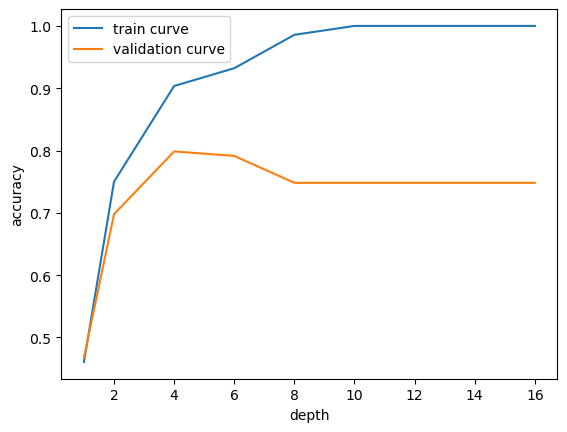

In [62]:

# Plot the validation curves
plt.plot(gs_results_pca["depth"], gs_results_pca["train_accuracy"], label="train curve")
plt.plot(gs_results_pca["depth"], gs_results_pca["valid_accuracy"], label="validation curve")
plt.ylabel("accuracy")
plt.xlabel("depth")
plt.legend()
plt.show()

In [63]:
# Get entry with the best validation MSE
best_result = gs_results_pca.loc[gs_results_pca.valid_accuracy.idxmax()]

# Print the details
print("Best depth: {}".format(best_result.depth))
print("Validation Accuracy: {:.4f}".format(best_result.valid_accuracy))

Best depth: 4.0
Validation Accuracy: 0.7986


*Comments:* The result is better when we use a PCA first. Indeed, we can increase the accuracy to 79% with a pca transformed data set. The best depth is then 4. We can mention that having a max depth of 6 provides good results as well.

### Try a random forest model and tune the number of trees and their depth. Does increasing the number of trees help? Is there an optimal depth and how does it compare to your decision tree above?

*Comments:" I am tuning the parameters *depth* and *number of trees* using a parameter grid. After defining a set of reasonable features, we create a pipeline to tune and assess the accuracy of the random forest model on 5-fold-cross-validation  

In [26]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import ParameterGrid

In [27]:
# Define a set of reasonable values for the depth and number of estimators of the forest
d_val = np.arange(3, 9, 1)  # 1, 2, 3, .., 20
nb_trees = np.arange(25, 60, 5)

In [28]:
# Visualize the set of values
d_val, nb_trees

(array([3, 4, 5, 6, 7, 8]), array([25, 30, 35, 40, 45, 50, 55]))

In [29]:
# Create the pipeline and parameter grid
# Random Forest pipeline
rf_pipe = Pipeline(
    [
        ("scaler", StandardScaler()),  # Standardization step
        ("rf", RandomForestClassifier(random_state=0)),  # Random Forest classifier
    ]
)

# Hyperparameter grid
param_grid = ParameterGrid({
    "rf__n_estimators": nb_trees,  # Number of trees in the forest
    "rf__max_depth": d_val,       # Maximum depth of the trees
})

# Print the number of combinations
print("Number of combinations:", len(param_grid))


Number of combinations: 42


In [30]:
# Grid search with cross-validation
grids = [
    {"rf__n_estimators": nb_trees, "rf__max_depth": d_val
    },
]
rf_gscv = GridSearchCV(
    rf_pipe, grids, cv=5, refit=True, return_train_score=True
)

In [31]:
# confirm the list of values in the grid search CV
list(grids)

[{'rf__n_estimators': array([25, 30, 35, 40, 45, 50, 55]),
  'rf__max_depth': array([3, 4, 5, 6, 7, 8])}]

In [32]:
# Create a dataframe to store the accuracy and parameter values
import warnings
from sklearn.exceptions import ConvergenceWarning

# Filter convergence warnings
warnings.simplefilter("ignore", ConvergenceWarning)

# Fit/evaluate estimator
rf_gscv.fit(X_tr, y_tr)

# Collect results in a DataFrame
rf_results = pd.DataFrame(
    {
        "nb_trees": rf_gscv.cv_results_["param_rf__n_estimators"],
        "max_depth": rf_gscv.cv_results_["param_rf__max_depth"],
        "mean_tr": rf_gscv.cv_results_["mean_train_score"],
        "mean_te": rf_gscv.cv_results_["mean_test_score"],
        "std_te": rf_gscv.cv_results_["std_test_score"],
    }
)

# Ten best combinations according to the mean test score
rf_results.sort_values(by="mean_te", ascending=False).head(10)

,nb_trees,max_depth,mean_tr,mean_te,std_te
34,55,7,1.0,0.896429,0.030723
32,45,7,1.0,0.892857,0.027664
33,50,7,1.0,0.892857,0.025254
29,30,7,1.0,0.889286,0.042857
31,40,7,1.0,0.889286,0.036422
40,50,8,1.0,0.882143,0.033120
30,35,7,1.0,0.882143,0.040089
41,55,8,1.0,0.875000,0.027664
39,45,8,1.0,0.875000,0.029881
28,25,7,1.0,0.871429,0.044320


In [33]:
# Get the best depth value from the grid search
best_depth = rf_gscv.best_params_['rf__max_depth']
print(f"Best depth: {best_depth}")

Best depth: 7


In [34]:
# Get the best nb of tree value from the grid search
best_trees = rf_gscv.best_params_['rf__n_estimators']
print(f"Best nb of tree: {best_trees}")

Best nb of tree: 55


*Comments:* The optimal tree depth after tuning is 7 with 55 trees. Increasing the number of estimators significantly improves the model's performance, achieving an accuracy of 86%, compared to 80% with just a single estimator. It is worth noting that the depth of each tree is very similar to the depth obtained after tuning a single decision tree. We are now fitting the model on the combined training and validation sets before predicting the results and evaluating the score on the test set.

In [66]:
X_final = np.concatenate((X_tr, X_val), axis=0) 
y_final = np.concatenate((y_tr, y_val), axis=0) 
X_final.shape, y_final.shape

((419, 1280), (419,))

In [68]:
# Create a new estimator using only the best hyperparameters values
final_estimator = rf_pipe.set_params(rf__n_estimators=best_trees, rf__max_depth=best_depth)

# Fit the final estimator with the trainning data
final_estimator.fit(X_final, y_final)

Pipeline(steps=[('scaler', StandardScaler()),
                ('rf',
                 RandomForestClassifier(max_depth=7, n_estimators=55,
                                        random_state=0))])

In [71]:
# Calculating the score 
dt_score = final_estimator.score(X_te, y_te) * 100
dt_score

92.3076923076923

In [73]:
#Save the score in the SQL Table 
import sqlite3

dt_data = {'model': ['Random Forest'],
        'test_accuracy': [dt_score]}
dt_df = pd.DataFrame(dt_data)

# Save to SQLite
conn = sqlite3.connect('results.db')
dt_df.to_sql('results_table', conn, if_exists='append', index=False)
conn.close()

### The random forest estimator provides a ranking of the features according to their importance in the classification task via thefeature_importances_ attribute. Find the the top 5 important features and visualize their importance scores.

To achieve this, I am creating a model tuned with the best hyperparameters. Then, I retrieve and sort the feature coefficients of this model in the same way as in the previous sections.

In [36]:
# Access the model using "names_steps"
final_rf = final_estimator.named_steps["rf"]
# Extracting the coefficient of each features
rf_features = final_rf.feature_importances_
rf_features

array([3.75905964e-03, 1.62834565e-03, 6.08840914e-04, ...,
       0.00000000e+00, 3.59684951e-03, 8.05549082e-05])

In [37]:
# Sort the coefficients in descending order
sorted_indices = np.argsort(rf_features)[::-1]  # Indices sorted values in descending order
sorted_values = rf_features[sorted_indices] #sorted coefficients


In [38]:
# Create a DataFrame with the results
sorted_coeff = pd.DataFrame({
    "Index": sorted_indices,
    "Values": sorted_values
})
sorted_coeff.head(5)

,Index,Values
0,466,0.018985
1,44,0.018062
2,892,0.014267
3,999,0.014263
4,783,0.014166


*Comments:" We can see that feature 466, which has the highest importance among the 1280 features, was selected during the EDA phase. However, none of these top 5 features appear in the features selected during the logistic regression phase." 
Overall, we can see that each model look to select its own features to classify data. Have 1 or 2 features in common among 1280 features can be considered as an interesting result. 